In [1]:
# 2 min
!pip install -q -q -q tifffile
!pip install -q -q -q tqdm # progresbar
!pip3 install -q -q -q torch==1.9.0+cu102 torchvision==0.10.0+cu102 torchaudio===0.9.0 -f https://download.pytorch.org/whl/torch_stable.html

In [2]:
#%load_ext autoreload
#%autoreload 2

import os
import s3fs
import shutil
import torch

from pathlib import Path
import random
from collections import OrderedDict

import numpy as np
from tifffile import TiffFile
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from tqdm import tqdm
from PIL import Image
from torch.utils.data import DataLoader,  random_split
from torch.utils.data.dataset import Dataset
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim



In [3]:
if torch.cuda.is_available() : device= torch.device("cuda:0" )
else : device = "cpu"

print("Using {} device".format(device))
if torch.cuda.is_available() :
    print("nom du GPU :", torch.cuda.get_device_name(device=None))
    print("GPU initialisé : ", torch.cuda.is_initialized())

Using cuda:0 device
nom du GPU : Tesla T4
GPU initialisé :  True


## Objectif

Ici, on veut réaliser une segmentation d'images satellites. ce problème est plus complexe que celui de la classificaton d'image dans la mesure où l'on souhaite ici attribuer à chaque pixel d'une image satellite donnée un type de classification du sol ( eau, bâtiment, surface cultivée etc..)

## Chargement des données

In [4]:
fs = s3fs.S3FileSystem(client_kwargs={'endpoint_url': 'https://minio.lab.sspcloud.fr'})
fs.get('projet-funathon/Sujet9_deep_learning_donnees_satellites/additional_files_earthcube_emu4zqr.zip', 'additional_files_earthcube_emu4zqr.zip')
shutil.unpack_archive('additional_files_earthcube_emu4zqr.zip')

Comme dans l'exemple précédent on récupère l'ensemble des chemins de fichiers correspondants aux images satellites utilisées ainsi que l'ensemble des labels associés
Notez qu'ici les labels ne sont plus un chiffre (ex: 0-chat, 1-chie) nmais un tableau de même dimensionque l'image donnant pour chaque pixel de cette dernière un label correspondant au type d'occupation du sol (de 1 à 9). On appelle ces labels particuliers des **masques**

Les images utlisées ici ont en plus des 3 channels habituels (R, G, B) un 4 ème channel correspondant à la mesure de la bande infra rouge. En pratique beaucoup d'autres bandes spectrales sont disponibles pour les images satellites, cet exercice se restreint seulement aux 4 bandes (R,G,B, Infra)

In [5]:
DATA_FOLDER_STR = 'dataset'
DATA_FOLDER = Path(DATA_FOLDER_STR).expanduser()
DATASET_FOLDER = DATA_FOLDER

# get all train images and masks
train_images_paths = sorted(list(DATASET_FOLDER.glob('train/images/*.tif')))
train_masks_paths = sorted(list(DATASET_FOLDER.glob('train/masks/*.tif')))


On crée ici la classe CustomDataset qui nous permettra d'accéder aux images satellites et aux masques, comme dans l'exemple précédent

In [6]:
class CustomDataset(Dataset):
    def __init__(self, image_paths,mask_paths):   # initial logic happens like transform
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        
    def __getitem__(self, idx):
        
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        with TiffFile(self.mask_paths[idx]) as tif :
            mask = tif.asarray()
        
        with TiffFile(self.image_paths[idx]) as tif :
            image = np.array(tif.asarray())
     
        t_mask = torch.tensor(mask,dtype = torch.long)
        image = torch.tensor(np.array(image,dtype = float), dtype =torch.float)
        
        ID = str(self.mask_paths[idx])
     
        return {"image": image, "masque" : t_mask, "id" : ID} 
        
        
    def __len__(self):  
        return len(self.mask_paths)
    


La class LandCoverData donne des informations en dur sur notre jeu d'image. 

In [7]:
class LandCoverData():
   
    IMG_SIZE = 256
    N_CHANNELS = 4
    N_CLASSES = 10
    MEAN_CHANNEL = [ 339.42029674, 570.98497474,  539.11161384, 2634.49868179] 
    STD_CHANNEL = [ 339.79895785, 404.86935149,  549.41877854, 1071.38939764]
    COUNT_CLASS =  np.array([0, 20643, 60971025, 404760981, 277012377, 96473046, 333407133, 9775295, 1071, 29404605])
    WEIGHT_CLASS = np.array([0.0000e+00, 0.0000e+00, 1.6401e-08, 2.4706e-09, 3.6099e-09, 1.0366e-08,
        2.9993e-09, 1.0230e-07, 9.3371e-04, 3.4008e-08])*np.sum(COUNT_CLASS)
    CLASSES = [
    'no_data',
    'clouds',
    'artificial',
    'cultivated',
    'broadleaf',
    'coniferous',
    'herbaceous',
    'natural',
    'snow',
    'water']
    
    TRAINSET_SIZE = 18491
    TESTSET_SIZE = 5043
    
    CLASSES_COLORPALETTE = {
    0: [0,0,0],
    1: [255,25,236],
    2: [215,25,28],
    3: [211,154,92],
    4: [33,115,55],
    5: [21,75,35],
    6: [118,209,93],
    7: [130,130,130],
    8: [255,255,255],
    9: [43,61,255]
    }
    CLASSES_COLORPALETTE = {c: np.asarray(color) for (c, color) in CLASSES_COLORPALETTE.items()}



**Test du Dataset**

In [8]:
dataset = CustomDataset(train_images_paths,train_masks_paths)

# construction d'un itérateur
iterateur = iter(dataset)

# récupération du premier jeu (image,masque) du dataset
element_dataset = next(iterateur)
image = element_dataset["image"]
masque = element_dataset["masque"]

print(image.shape)
print(masque.shape)


torch.Size([256, 256, 4])
torch.Size([256, 256])


Le masque a bien les mêmes dimenssions que l'image associée

## Montrer une image et un masque

In [9]:
def show_image(image, display_min=50, display_max=400, ax=None):
    """Show an image.
    Args:
        image (numpay.array[uint16]): the image. If the image is 16-bit, apply bytescaling to convert to 8-bit
    """
    if image.dtype == np.uint16:
        iscale = display_max - display_min
        scale = 255 / iscale
        byte_im = (image) * scale
        byte_im = (byte_im.clip(0, 255) + 0.5).astype(np.uint8)
        image = byte_im
    # show image
    plt.imshow(image)
    plt.show()

def show_mask(mask, classes_colorpalette, classes=None, add_legend=True, ax=None):
    """Show a a semantic segmentation mask.
    Args:
       mask (numpy.array[uint8]): the mask in 8-bit
       classes_colorpalette (dict[int, tuple]): dict mapping class index to an RGB color in [0, 1]
       classes (list[str], optional): list of class labels
       add_legend
    """
    show_mask = np.empty((*mask.shape, 3))
    for c, color in classes_colorpalette.items():
        show_mask[mask == c, :] = color
    show_mask = show_mask.astype(np.uint8)
    
    plt.imshow(show_mask)
    handles = []
    for c, color in LandCoverData.CLASSES_COLORPALETTE.items():        
        handles.append(mpatches.Patch(color=color/255, label=LandCoverData.CLASSES[c]))
    plt.legend(handles=handles)
    plt.show()
    

Image


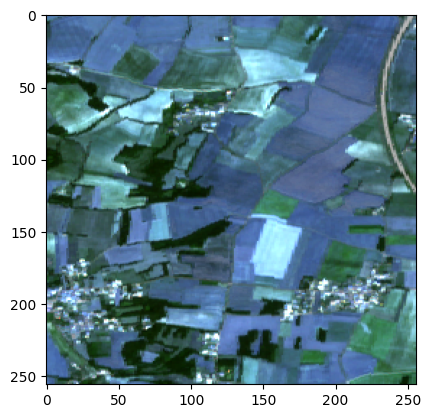

masque


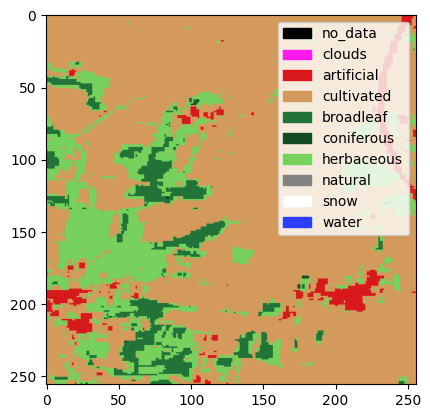

In [10]:
print("Image")
show_image(np.array(image).astype(np.uint16),display_min = 0, display_max = 2200)

print("masque")
show_mask(np.array(masque),LandCoverData.CLASSES_COLORPALETTE)

Le dictionnaire config contient tous les hyperparamètres nécessaires pour l'entraînement

In [11]:
config ={
    'monitoring' : True,
    'freq monitoring':50,
    'n_epoch' : 80,
    'train_size' : 15000,
    'batch_size' :  28,
    'optimizer' : "SGD",
    'lr' : 0.003,    
    'momentum' : 0.9,
    'model type': "segmentation mask",
    'init_features'  : 16,
    'validation_n_batch' : 2000,
    'descriptif': "Entrainement avec un unet pour segmentation + cross entropy"
}

On crée ici le DataLoader qui va nous permettre de charger les images et leur label par paquet

In [12]:

batch_size =  config['batch_size']
all_dataset = CustomDataset(train_images_paths,train_masks_paths)
all_loader = DataLoader(all_dataset, batch_size=batch_size, shuffle=True, num_workers=0)

train_size = config['train_size']
val_size = len(all_dataset.mask_paths) - train_size
#dans la liste donner la taille du train et la taille deu test
train_dataset, valid_dataset = random_split(all_dataset,[train_size,val_size], generator=torch.Generator().manual_seed(42))

train_loader = DataLoader(train_dataset, batch_size=batch_size, 
                          shuffle=True, num_workers=0)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True, num_workers=0)

## Définition d'un modèle U-net

Comme dans l'exemple sur la classification, on définit un modèle convolutif bien plus touffu que le précédent. Ce type de modèle est très utilisé dans la littérature pour répondre au problème de segmentation sémantique (délimitation + labellisation de zones dans une image).

Ce Unet est composé : 
- d'une phase descendante qui extrait des caractéristiques de l'image 
- d'une phase descendante qui à partir des caractéristiques extraites réalisera la classification de l'image en entrée pixel par pixel

Pour plus d'information sur le Unet :
https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=&cad=rja&uact=8&ved=2ahUKEwj0746Sva34AhWSBhoKHVtvDrIQFnoECAoQAQ&url=https%3A%2F%2Farxiv.org%2Fabs%2F1505.04597&usg=AOvVaw2VMp5nhjei6r-QgaG3XTpUhttps://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=&cad=rja&uact=8&ved=2ahUKEwj0746Sva34AhWSBhoKHVtvDrIQFnoECAoQAQ&url=https%3A%2F%2Farxiv.org%2Fabs%2F1505.04597&usg=AOvVaw2VMp5nhjei6r-QgaG3XTpU

La construction est détaillée ci-dessous. Le paramètre "init_features" permettra de jouer sur la taille de réseau que l'on souhaite obtenir

In [15]:

class Unet(nn.Module):
    def __init__(self, init_features,in_channels=4, out_channels=10):
        super(Unet, self).__init__()
        features = init_features
        self.encoder1 = Unet._block(in_channels, features, name="enc1")
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder2 = Unet._block(features, features * 4, name="enc2")
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.bottleneck = Unet._block(features * 4, features * 8, name="bottleneck")

        self.upconv2 = nn.ConvTranspose2d(
            features * 8, features * 4, kernel_size=2, stride=2
        )
        self.decoder2 = Unet._block((features * 4) * 2, features * 4, name="dec2")
        self.upconv1 = nn.ConvTranspose2d(
            features * 4, features, kernel_size=2, stride=2
        )
        self.decoder1 = Unet._block(features * 2, features, name="dec1")

        self.conv = nn.Conv2d(
            in_channels=features, out_channels=out_channels, kernel_size=1
        )

    def forward(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool1(enc1))
        
        bottleneck = self.bottleneck(self.pool2(enc2))

        dec2 = self.upconv2(bottleneck)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.decoder2(dec2)
        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.decoder1(dec1)
        
        return torch.sigmoid(self.conv(dec1))

    @staticmethod
    def _block(in_channels, features, name):
        return nn.Sequential(
            OrderedDict(
                [
                    (name + "conv1", nn.Conv2d(in_channels=in_channels, out_channels=features, kernel_size=3, padding=1, bias=False,),),
                    (name + "Batchnorm1", nn.BatchNorm2d(num_features=features)),
                    (name + "relu1", nn.ReLU(inplace=True)),
                    (name + "conv2",nn.Conv2d(in_channels=features, out_channels=features, kernel_size=3, padding=1, bias=False,),),
                    (name + "Batchnorm2", nn.BatchNorm2d(num_features=features)),
                    (name + "relu2", nn.ReLU(inplace=True)),
                ]
            )
        )

    


Pour information, la cellule ci-dessous présente une méthode de construction du U-net
où on récupère ici une structure de modèle sur https://github.com/mateuszbuda/brain-segmentation-pytorch

In [32]:
class Unet_dl(nn.Module):
    def __init__(self,init_features):
        super().__init__()
        self.unet = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet',
        in_channels= 4, out_channels=10, init_features= init_features, pretrained=False, verbose = False)

    def forward(self,x):
        x = self.unet(x)
        return(x)

**comptons le nombre de paramètres**

In [21]:
def get_n_params(model):
    pp=0
    for p in list(model.parameters()):
        nn=1
        for s in list(p.size()):
            nn = nn*s
        pp += nn
    return pp

In [22]:
net = Unet(config['init_features'])
get_n_params(net) 

425914

**Remarque :** Près d'un demi-million de paramètres pour ce réseau ce qui est bien plus élevé que les 75000 paramètres du réseau précédent !

## Entraînement du modèle

De la même façon que précedemment On va entraîner notre modèle, la logique reste la même :
On actualise les paramètres du modèle, batch après batch en calculant une erreur commise par le modèle sur le batch.
L'erreur commise pour une image est la moyenne des erreurs commises sur les labels de chacun de ses pixels (entropy croisée)

In [34]:
net = Unet(config['init_features'])

**Remarque** Même avec un GPU l'entraînement d'un modèle aussi gros peut  prendre une quinzaine d'heures. C'est pourquoi nous vous invitons à lancer la cellule ci-dessous pour constater que l'entraînement se lance bien. Puis vous pouvez arrêter l'entraînement et passer à la partie suivnte permettant de charger des modèles qui ont été pré-entrainés pour vous par nos soisn.

In [23]:
optimizer = optim.SGD(net.parameters(), lr=config['lr'], momentum=config['momentum'])

net = net.to(device)

entropy = nn.CrossEntropyLoss()

for epoch in range(config['n_epoch']): 
    
       
        net = net.to(device)    

        running_loss = 0.0

        t= tqdm(train_loader, desc="epoch %i" % (epoch+1),position = 0, leave=True)
        epoch_loop = enumerate(t)

        for i, data in epoch_loop:

            taille_batch = data['image'].shape[0]
            images = data['image'].permute(0,3,1,2)
            masques  =  data['masque']

            
            images, masques = images.to(device), masques.long().to(device)

            y_hat = net(images)

            optimizer.zero_grad()
            loss = entropy(y_hat,masques)

            loss.backward()
            optimizer.step()

            del images, masques, y_hat # libéreer un peu d'espace

            running_loss += loss.item()
            if (i+1) % config['freq monitoring'] == 0:  
                t.set_description("epoch %i, 'mean loss: %.6f'" % (epoch+1,running_loss/config['freq monitoring']))
                t.refresh()
                running_loss =0


epoch 1:   0%|          | 0/536 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
epoch 1:   1%|          | 3/536 [00:33<1:39:36, 11.21s/it]


KeyboardInterrupt: 

## Récupération de modèles pré-entrainés et Sauvegarde de modèle

On extrait du bucket "projet-funathon" les modèles pré-entrainés.

In [17]:
fs.get('projet-funathon/Sujet9_deep_learning_donnees_satellites/model_Unet_initfeatures_6.pth', 'Unet_pre_entraine_peu_profond.pth')
fs.get('projet-funathon/Sujet9_deep_learning_donnees_satellites/model_config_init_16.pth', 'Unet_pre_entraine_profond.pth')

[None]

Ces modèles ont été entrainés sur une centaine d'epochs (10h d'entraînement pour le plus profond).
Lorsqu'on veut récupérer le modèle entraîné, il est nécessaire en premier lieu d'inialiser un Unet non entraîné avec exactement la même structure que le modèle pré entrainé ! Puis on charge les paramètres enregistrés précedemment en son sein.
Le Unet_pre_entraine_peu_profond a été entrainé avec init_features = 6, le U_net_profond avec init features = 16 

In [18]:
Unet_peu_profond = Unet(6) # création d'un modèle avec 6 init features en entrée non entrainé
Unet_peu_profond.load_state_dict(torch.load('Unet_pre_entraine_peu_profond.pth')) # remplacement des paramètres par les paramètres issus du modèle pré entraîné


Unet_profond = Unet(16) # création d'un modèle avec 6 init features en entrée non entrainé
Unet_profond.load_state_dict(torch.load('Unet_pre_entraine_profond.pth')) # remplacement des paramètres par les paramètres issus du modèle pré entraîné


<All keys matched successfully>

Il est intéressant de comparer le nombre de paramètres contenu dans chaque modèle

In [19]:
get_n_params(Unet_peu_profond)

60364

In [20]:
get_n_params(Unet_profond)

425914

Le Unet profond a beaucoup plus de paramètres, il sera plus long a entraîner. Cependant, à nombre d'epochs égal ce dernier sera plus précis dans la tâche de segmentation d'images satellites

Pour information, pour **sauvegarder** les paramètres d'un modèle les instructions suivantes suffisent :

In [24]:
torch.save(net.state_dict(), 'model_test_enregistrement.pth') #(devrait apparaître à gauche dans les dossiers)

## Evaluation qualitatives des modèles des modèle

Ici on prend des images de l'échantillon de validation, images n'ayant pas servi à l'entraînement
On compare les masques obtenus avec les deux modèles entraînés (Unet profond et peu profond) aux vrais masques (fournis par nos soins)
Relancez plusieurs fois pour constater que lees masques produits par le modèle peu profond sont plus fidèles aux vrais masques.

Image initiale


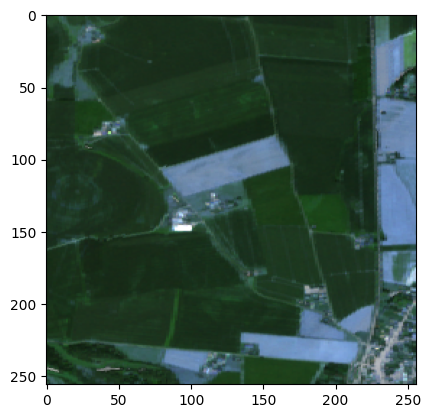

Masque prédit Unet peu profond


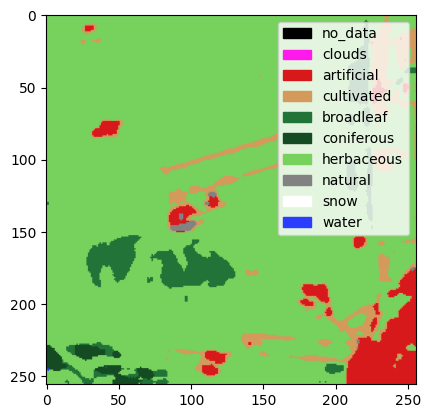

Masque prédit Unet profond


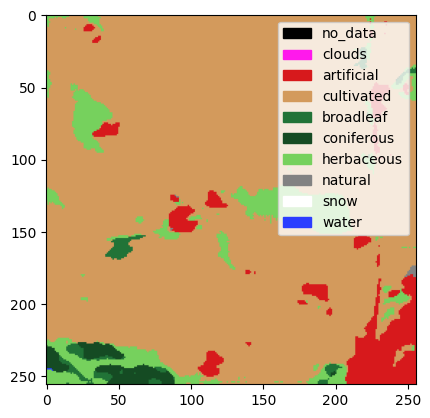

Vrai masque


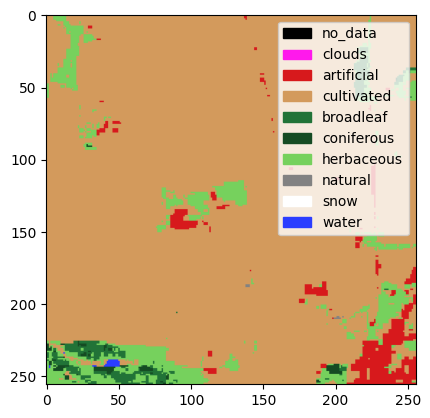

In [25]:
# Chargement
tmp =iter(valid_loader)
dico =next(tmp)
images =dico['image']
masques_true = dico['masque']

net = Unet_peu_profond.to(device)
masque_predit = net(images.permute(0,3,1,2).to(device))
masque_predit = masque_predit[0]
masque_unet_peu_profond = np.array(torch.argmax(masque_predit,dim=0).cpu()).astype(np.uint8)

net = Unet_profond.to(device)
masque_predit = net(images.permute(0,3,1,2).to(device))
masque_predit = masque_predit[0]
masque_unet_profond = np.array(torch.argmax(masque_predit,dim=0).cpu()).astype(np.uint8)


masque_true = masques_true[0]
image_select = images[0]

img = np.array(image_select).astype(np.uint16)

print("Image initiale")
show_image(img,display_min = 0, display_max = 2200)

print("Masque prédit Unet peu profond")
show_mask(masque_unet_peu_profond,LandCoverData.CLASSES_COLORPALETTE)

print("Masque prédit Unet profond")
show_mask(masque_unet_profond,LandCoverData.CLASSES_COLORPALETTE)

print("Vrai masque")
show_mask(masque_true,LandCoverData.CLASSES_COLORPALETTE)
